### Necessary Packages

In [1]:
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader,Subset
from torch import nn,Tensor
from torch.optim import Adam
from typing import Callable,Optional,Any
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision.models import efficientnet_b0,shufflenet_v2_x1_0
from torchvision.models import ShuffleNet_V2_X1_0_Weights,EfficientNet_B0_Weights
from torchsummary import summary
from torchmetrics import Accuracy,F1Score,Recall,Precision,AUROC,Metric
from trainer.trainer import Trainer
from tqdm.notebook import tqdm

### Global

In [2]:
DATASET_PATH = os.path.join(".", "COVID-19_Radiography_Dataset")
WORKING_DIR = os.path.join(".", "working")
WEIGHTS_FOLDER = os.path.join(WORKING_DIR, "weights")
HISTORY_FOLDER = os.path.join(WORKING_DIR, "histories")
FIGURES_FOLDER = os.path.join(WORKING_DIR, "figures")
TEST_SIZE = 0.3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WROKERS = 4
PREFETCH_FACTOR = 2

In [3]:
print(DATASET_PATH)
print(WORKING_DIR)
print(WEIGHTS_FOLDER)
print(HISTORY_FOLDER)
print(FIGURES_FOLDER)
print(DEVICE)

./COVID-19_Radiography_Dataset
./working
./working/weights
./working/histories
./working/figures
cuda


In [4]:
def init():

    if not os.path.exists(WEIGHTS_FOLDER):
        os.mkdir(WEIGHTS_FOLDER)
        
    if not os.path.exists(HISTORY_FOLDER):
        os.mkdir(HISTORY_FOLDER)

    if not os.path.exists(FIGURES_FOLDER):
        os.mkdir(FIGURES_FOLDER)

In [5]:
init()

### Hyper parameters

In [6]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20

### Data Loading and preprocessing

In [7]:
class Covid19Dataset(Dataset):
    
    def __init__(self, 
        root : str, 
        image_transform : Optional[Callable] = None,
        label_transform : Optional[Callable] = None,
    ) -> None:
        self.root = root
        self.paths,self.labels,self.idx_to_class,self.class_to_index = self._find_classes()
        self.image_transform = image_transform
        self.label_transform = label_transform
    
    def _find_classes(self) -> tuple[list[str],list[int],list[str],dict[str,int]]:
        
        idx_to_class = os.listdir(self.root)
        idx_to_class = filter(lambda f : os.path.isdir(os.path.join(self.root, f)), idx_to_class)
        idx_to_class = list(idx_to_class)
        
        paths = []
        labels = []
        
        class_to_idx = {}
        
        for i,class_ in enumerate(idx_to_class):
            class_to_idx[class_] = i
        
        for class_ in idx_to_class:
            
            class_path = os.path.join(self.root, class_, 'images')
            
            for imagename in os.listdir(class_path):
                
                image_path = os.path.join(class_path, imagename)
                
                paths.append(image_path)
                labels.append(class_to_idx[class_])
                
        return paths,labels,idx_to_class,class_to_idx
    
    def __getitem__(self, index : int):
        
        path = self.paths[index]
        label = self.labels[index]
        
        img = Image.open(path).convert("RGB")
        
        if self.image_transform:
            img = self.image_transform(img)
            
        if self.label_transform:
            label = self.label_transform(label)
            
        return img,label
        
    def __len__(self) -> int:
        return len(self.paths)

In [8]:
dataset = Covid19Dataset(DATASET_PATH)

In [9]:
len(dataset)

21165

### Data Splitting

In [10]:
indices = [i for i,label in enumerate(dataset.labels)]
y = dataset.labels

In [11]:
train_indices, test_indices = train_test_split(indices, test_size=TEST_SIZE, stratify=y, shuffle=True)

In [12]:
print(len(train_indices), len(test_indices))

14815 6350


### Models

In [13]:
class Classifier(nn.Module):

    def __init__(self, in_features : int, out_features : int):

        super().__init__()

        self.in_features = in_features
        self.out_features = out_features

        self.layers = nn.Sequential(
            nn.Linear(
                in_features=in_features,
                out_features=1024
            ),
            nn.ReLU(),
            nn.Linear(
                in_features=1024,
                out_features=512
            ),
            nn.ReLU(),
            nn.Linear(512, out_features)
        )

    def forward(self, x : torch.Tensor):
        return self.layers(x)

In [14]:
class EfficientNet(nn.Module):
    
    def __init__(self, weights : EfficientNet_B0_Weights, num_classes : int, depth : int):
        
        super().__init__()
        
        self.num_classes = num_classes
        self.depth = depth
        
        ### Load the model's weights
        self._model = efficientnet_b0(weights=weights)
        
        ### remove the last layer
        classification_layers = list(self._model.classifier.modules())
        self._model.classifier = nn.Identity()
        
        ### freeze the model
        for param in self._model.parameters():
            param.requires_grad = False
            
        if depth > 0:
            for module in self._model.features[-depth:]:
                for param in module.parameters():
                    param.requires_grad = True

        ### add a fully connected layer with appropriate number of classes
        self.classifier = Classifier(in_features=classification_layers[-1].in_features, out_features=self.num_classes)
        
    def forward(self, x : Tensor) -> Tensor:
        y = self._model(x)
        y = self.classifier(y)
        return y

In [15]:
class ShuffleNet(nn.Module):
    
    def __init__(self,  weights : ShuffleNet_V2_X1_0_Weights, num_classes : int, depth : int):
        
        super().__init__()
        
        self.num_classes = num_classes
        self.depth = depth
        
        ### Load the weights
        self._model = shufflenet_v2_x1_0(weights)
        
        ### Freeze all the other layers
        for param in self._model.parameters():
            param.requires_grad = False
        
        blocks = [
            self._model.conv1,
            self._model.stage2,
            self._model.stage3,
            self._model.stage4,
            self._model.conv5
        ]
        
        if depth > 0:
            for module in blocks[-depth:]:
                for param in module.parameters():
                    param.requires_grad = True
            
        self.classifier = Classifier(in_features=self._model.fc.in_features, out_features=self.num_classes)
        
        ### Remove the last layer
        self._model.fc = nn.Identity()
        
    def forward(self, x : Tensor):
        y = self._model(x)
        y = self.classifier(y)
        return y

In [16]:
num_classes = len(dataset.class_to_index)
print(num_classes)

4


### Models creation

In [17]:
model_descriptors = [
    {
        "weights" : EfficientNet_B0_Weights.IMAGENET1K_V1,
        "class" : EfficientNet,
        "depth" : 0
    },
    {
        "weights" : ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1,
        "class" : ShuffleNet,
        "depth" : 0
    },
    {
        "weights" : EfficientNet_B0_Weights.IMAGENET1K_V1,
        "class" : EfficientNet,
        "depth" : 1
    },
    {
        "weights" : ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1,
        "class" : ShuffleNet,
        "depth" : 1
    },
    {
        "weights" : EfficientNet_B0_Weights.IMAGENET1K_V1,
        "class" : EfficientNet,
        "depth" : 2
    },
    {
        "weights" : ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1,
        "class" : ShuffleNet,
        "depth" : 2
    },
]

In [18]:
def create_dataloaders(
    dataset : Dataset, 
    train_indices : list[int], 
    test_indices : list[int], 
    batch_size : int,
    num_workers : int,
    prefetch_factor : int
):
    
    train_data = Subset(dataset, train_indices)
    test_data = Subset(dataset, test_indices)
    
    train_loader = DataLoader(dataset=train_data,shuffle=True,batch_size=batch_size,num_workers=num_workers,prefetch_factor=prefetch_factor)
    test_loader = DataLoader(dataset=test_data,shuffle=True,batch_size=batch_size,num_workers=num_workers,prefetch_factor=prefetch_factor)
    
    return train_loader,test_loader

In [19]:
def create(
    model_descriptors : list[dict[str,Any]], 
    root : str,
    train_indices : int,
    test_indices : int,
    batch_size : int,
    device : torch.device,
    num_workers : int,
    prefetch_factor : int
):
    
    models = {}
    
    for model_descriptor in model_descriptors:

        model = {}
        
        weights = model_descriptor["weights"]
        depth = model_descriptor["depth"]
        transforms = weights.transforms()
        dataset = Covid19Dataset(root, transforms)
        num_classes = len(dataset.idx_to_class)
        
        train_loader,test_loader = create_dataloaders(dataset, train_indices, test_indices, batch_size, num_workers=num_workers,prefetch_factor=prefetch_factor)
        
        model = model_descriptor["class"](weights, num_classes, depth).to(device)
        
        models[f"net={model.__class__.__name__}&depth={depth}"] = {
            "train_loader" : train_loader,
            "test_loader" : test_loader,
            "model" : model
        }
        
    return models

In [20]:
models = create(model_descriptors, DATASET_PATH, train_indices, test_indices, BATCH_SIZE, DEVICE, NUM_WROKERS, PREFETCH_FACTOR)

/home/abdelnour/anaconda3/envs/project/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [21]:
model_names = list(models.keys())

In [22]:
model_names

['net=EfficientNet&depth=0',
 'net=ShuffleNet&depth=0',
 'net=EfficientNet&depth=1',
 'net=ShuffleNet&depth=1',
 'net=EfficientNet&depth=2',
 'net=ShuffleNet&depth=2']

### Print the architectures' summaries

In [23]:
def print_model_summary(models, key : str, device = DEVICE):
    x, y = next(iter(models[key]["train_loader"].dataset))
    print(f"{models[key]["model"].__class__.__name__}, depth = {models[key]["model"].depth}")
    summary(models[key]["model"], input_size=x.shape, device=device)

In [24]:
print_model_summary(models, model_names[0])

EfficientNet, depth = 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm

In [25]:
print_model_summary(models, model_names[1])

ShuffleNet, depth = 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d

In [26]:
print_model_summary(models, model_names[2])

EfficientNet, depth = 1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm

In [27]:
print_model_summary(models, model_names[3])

ShuffleNet, depth = 1
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d

In [28]:
print_model_summary(models, model_names[4])

EfficientNet, depth = 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm

In [29]:
print_model_summary(models, model_names[5])

ShuffleNet, depth = 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 58, 28, 28]           1,392
       BatchNorm2d-8           [-1, 58, 28, 28]             116
              ReLU-9           [-1, 58, 28, 28]               0
           Conv2d-10           [-1, 58, 56, 56]           1,392
      BatchNorm2d-11           [-1, 58, 56, 56]             116
             ReLU-12           [-1, 58, 56, 56]               0
           Conv2d-13           [-1, 58, 28, 28]             522
      BatchNorm2d

### Training

In [30]:
def train(models, name : str, epochs : int, weights_folder : str, history_folder : str) -> None:

    train_loader = models[name]["train_loader"]
    test_loader = models[name]["test_loader"]
    model = models[name]["model"]

    criteron = nn.CrossEntropyLoss()

    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

    accuracy = Accuracy(task="multiclass",num_classes=len(train_loader.dataset.dataset.idx_to_class)).to(DEVICE)

    trainer = Trainer() \
        .set_model(model) \
        .set_criteron(criteron) \
        .set_device(DEVICE) \
        .set_optimizer(optimizer) \
        .add_metric("accuracy", accuracy)
    
    trainer.train(train_loader, test_loader, epochs=epochs)

    torch.save(model.state_dict(), f=os.path.join(weights_folder, f"{name}.pt"))
    trainer.history.to_df().to_csv(os.path.join(history_folder, f"{name}.csv"), index=False)

In [31]:
train(models, model_names[0], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.9032257795333862,loss=0.267118901014328,: 100%|██████████| 463/463 [00:30<00:00, 15.09it/s]


100%|██████████| 199/199 [00:11<00:00, 16.94it/s]



Epoch 1 : Train Results : accuracy = 0.8272072911005041,loss = 0.4608523678316153 
 Validation Results : accuracy = 0.8820217155930984,loss = 0.3217445796533446



accuracy = 0.9677419066429138,loss=0.18379025161266327,: 100%|██████████| 463/463 [00:29<00:00, 15.61it/s]


100%|██████████| 199/199 [00:11<00:00, 17.30it/s]



Epoch 2 : Train Results : accuracy = 0.8726355116774145,loss = 0.3393911597184177 
 Validation Results : accuracy = 0.8778041996548523,loss = 0.3275120266942523



accuracy = 0.9354838728904724,loss=0.2822945713996887,: 100%|██████████| 463/463 [00:29<00:00, 15.63it/s]


100%|██████████| 199/199 [00:11<00:00, 17.46it/s]



Epoch 3 : Train Results : accuracy = 0.8845798787751414,loss = 0.3044159598085329 
 Validation Results : accuracy = 0.8842650753768844,loss = 0.30541531030257146



accuracy = 0.9354838728904724,loss=0.16083486378192902,: 100%|██████████| 463/463 [00:29<00:00, 15.60it/s]


100%|██████████| 199/199 [00:11<00:00, 18.05it/s]



Epoch 4 : Train Results : accuracy = 0.8963239392503034,loss = 0.2756945430492222 
 Validation Results : accuracy = 0.8855213567839196,loss = 0.30552045619068435



accuracy = 1.0,loss=0.10876648128032684,: 100%|██████████| 463/463 [00:29<00:00, 15.64it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.55it/s]



Epoch 5 : Train Results : accuracy = 0.9070599352051836,loss = 0.24545337044539384 
 Validation Results : accuracy = 0.8915559942997879,loss = 0.2878942968857348



accuracy = 0.8064516186714172,loss=0.5767134428024292,: 100%|██████████| 463/463 [00:29<00:00, 15.93it/s]


100%|██████████| 199/199 [00:11<00:00, 17.39it/s]



Epoch 6 : Train Results : accuracy = 0.9106240855694847,loss = 0.23283469372028667 
 Validation Results : accuracy = 0.8927001075528974,loss = 0.32514087436486727



accuracy = 0.8709677457809448,loss=0.1973648965358734,: 100%|██████████| 463/463 [00:29<00:00, 15.53it/s]


100%|██████████| 199/199 [00:11<00:00, 17.24it/s]



Epoch 7 : Train Results : accuracy = 0.9197402111139977,loss = 0.2097761611138384 
 Validation Results : accuracy = 0.8891555993401226,loss = 0.3129718585604399



accuracy = 0.9677419066429138,loss=0.060452900826931,: 100%|██████████| 463/463 [00:29<00:00, 15.63it/s]


100%|██████████| 199/199 [00:11<00:00, 17.27it/s]



Epoch 8 : Train Results : accuracy = 0.9216365915910214,loss = 0.2050617878279019 
 Validation Results : accuracy = 0.8919822325059517,loss = 0.3539415190005722



accuracy = 1.0,loss=0.05999496951699257,: 100%|██████████| 463/463 [00:30<00:00, 15.41it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.24it/s]



Epoch 9 : Train Results : accuracy = 0.9298056155507559,loss = 0.18575274844937525 
 Validation Results : accuracy = 0.8938666546165045,loss = 0.313903264907287



accuracy = 1.0,loss=0.051337312906980515,: 100%|██████████| 463/463 [00:30<00:00, 15.18it/s]    


100%|██████████| 199/199 [00:11<00:00, 16.83it/s]



Epoch 10 : Train Results : accuracy = 0.9381749460043196,loss = 0.16577117945837988 
 Validation Results : accuracy = 0.8897613065326633,loss = 0.3507110670995173



accuracy = 0.9032257795333862,loss=0.3594018816947937,: 100%|██████████| 463/463 [00:30<00:00, 15.24it/s]


100%|██████████| 199/199 [00:11<00:00, 17.05it/s]



Epoch 11 : Train Results : accuracy = 0.9419481118348453,loss = 0.15780089751336537 
 Validation Results : accuracy = 0.888617192980033,loss = 0.3541811628257809



accuracy = 0.9677419066429138,loss=0.13774070143699646,: 100%|██████████| 463/463 [00:30<00:00, 15.13it/s]


100%|██████████| 199/199 [00:12<00:00, 16.34it/s]



Epoch 12 : Train Results : accuracy = 0.9441797881352979,loss = 0.1499025238814641 
 Validation Results : accuracy = 0.8937544867620996,loss = 0.34847539935691574



accuracy = 0.9677419066429138,loss=0.06959684938192368,: 100%|██████████| 463/463 [00:31<00:00, 14.78it/s]


100%|██████████| 199/199 [00:12<00:00, 16.21it/s]



Epoch 13 : Train Results : accuracy = 0.9466095937508486,loss = 0.13767159239089288 
 Validation Results : accuracy = 0.8878768844221105,loss = 0.41057511827154974



accuracy = 0.9354838728904724,loss=0.3075554668903351,: 100%|██████████| 463/463 [00:31<00:00, 14.88it/s]


100%|██████████| 199/199 [00:12<00:00, 16.14it/s]



Epoch 14 : Train Results : accuracy = 0.9524119522092667,loss = 0.12632563191045632 
 Validation Results : accuracy = 0.8910175879396985,loss = 0.38632712573112554



accuracy = 0.9677419066429138,loss=0.11728496849536896,: 100%|██████████| 463/463 [00:31<00:00, 14.76it/s]


100%|██████████| 199/199 [00:12<00:00, 16.36it/s]



Epoch 15 : Train Results : accuracy = 0.9570712568178033,loss = 0.11100450551165489 
 Validation Results : accuracy = 0.8895145370133558,loss = 0.41686046184344805



accuracy = 0.9032257795333862,loss=0.31893569231033325,: 100%|██████████| 463/463 [00:29<00:00, 15.49it/s]


100%|██████████| 199/199 [00:11<00:00, 16.98it/s]



Epoch 16 : Train Results : accuracy = 0.9563244617268539,loss = 0.11898734300451647 
 Validation Results : accuracy = 0.8909278535962704,loss = 0.38779682021157524



accuracy = 0.9354838728904724,loss=0.10911519825458527,: 100%|██████████| 463/463 [00:29<00:00, 15.43it/s]


100%|██████████| 199/199 [00:11<00:00, 17.10it/s]



Epoch 17 : Train Results : accuracy = 0.9607812826628304,loss = 0.10827810675600749 
 Validation Results : accuracy = 0.8916008613217417,loss = 0.41177958755955174



accuracy = 1.0,loss=0.07118842005729675,: 100%|██████████| 463/463 [00:29<00:00, 15.72it/s]     


100%|██████████| 199/199 [00:11<00:00, 16.99it/s]



Epoch 18 : Train Results : accuracy = 0.9614605831533477,loss = 0.10357684226602026 
 Validation Results : accuracy = 0.8922290020252592,loss = 0.39483849379004693



accuracy = 1.0,loss=0.0371815450489521,: 100%|██████████| 463/463 [00:29<00:00, 15.49it/s]      


100%|██████████| 199/199 [00:11<00:00, 17.49it/s]



Epoch 19 : Train Results : accuracy = 0.9632154427645788,loss = 0.10259338603737175 
 Validation Results : accuracy = 0.892543072377018,loss = 0.4171303555313217



accuracy = 1.0,loss=0.04269655793905258,: 100%|██████████| 463/463 [00:29<00:00, 15.60it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.49it/s]



Epoch 20 : Train Results : accuracy = 0.9671976241900648,loss = 0.0957128625085525 
 Validation Results : accuracy = 0.8882133882848462,loss = 0.42765892701382613



In [32]:
train(models, model_names[1], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.8387096524238586,loss=0.4934130012989044,: 100%|██████████| 463/463 [00:20<00:00, 22.29it/s]


100%|██████████| 199/199 [00:08<00:00, 23.27it/s]



Epoch 1 : Train Results : accuracy = 0.7735447292708939,loss = 0.5767705763004254 
 Validation Results : accuracy = 0.8306039125476051,loss = 0.4674187968274457



accuracy = 0.9032257795333862,loss=0.24150466918945312,: 100%|██████████| 463/463 [00:20<00:00, 22.12it/s]


100%|██████████| 199/199 [00:08<00:00, 23.19it/s]



Epoch 2 : Train Results : accuracy = 0.8563649584871131,loss = 0.37929832782459566 
 Validation Results : accuracy = 0.8764806174153659,loss = 0.33516266331750544



accuracy = 0.8387096524238586,loss=0.4410839378833771,: 100%|██████████| 463/463 [00:22<00:00, 20.93it/s]


100%|██████████| 199/199 [00:09<00:00, 22.06it/s]



Epoch 3 : Train Results : accuracy = 0.8681046644760775,loss = 0.3501171343527396 
 Validation Results : accuracy = 0.8773555276381909,loss = 0.32593945492452114



accuracy = 0.8709677457809448,loss=0.2916572391986847,: 100%|██████████| 463/463 [00:22<00:00, 21.04it/s]


100%|██████████| 199/199 [00:08<00:00, 23.09it/s]



Epoch 4 : Train Results : accuracy = 0.8814032780686414,loss = 0.312016101139668 
 Validation Results : accuracy = 0.880877602339989,loss = 0.3145484849061798



accuracy = 0.9032257795333862,loss=0.2012241631746292,: 100%|██████████| 463/463 [00:21<00:00, 21.52it/s]


100%|██████████| 199/199 [00:09<00:00, 21.55it/s]



Epoch 5 : Train Results : accuracy = 0.8853201420724264,loss = 0.30558334999832426 
 Validation Results : accuracy = 0.8791950824272693,loss = 0.3155415264618157



accuracy = 0.9032257795333862,loss=0.38344046473503113,: 100%|██████████| 463/463 [00:22<00:00, 20.90it/s]


100%|██████████| 199/199 [00:09<00:00, 22.09it/s]



Epoch 6 : Train Results : accuracy = 0.8965242457441326,loss = 0.27726159589948457 
 Validation Results : accuracy = 0.8921841350033055,loss = 0.29512015447469814



accuracy = 0.9032257795333862,loss=0.19661836326122284,: 100%|██████████| 463/463 [00:21<00:00, 21.39it/s]


100%|██████████| 199/199 [00:09<00:00, 21.86it/s]



Epoch 7 : Train Results : accuracy = 0.9028687381847373,loss = 0.2593278842646283 
 Validation Results : accuracy = 0.8859475949900834,loss = 0.31154323466608874



accuracy = 0.9354838728904724,loss=0.1541026085615158,: 100%|██████████| 463/463 [00:21<00:00, 21.12it/s]


100%|██████████| 199/199 [00:09<00:00, 21.93it/s]



Epoch 8 : Train Results : accuracy = 0.9056381941099146,loss = 0.2496273764057113 
 Validation Results : accuracy = 0.8924084710116362,loss = 0.28231254609385925



accuracy = 0.9354838728904724,loss=0.23821374773979187,: 100%|██████████| 463/463 [00:22<00:00, 20.95it/s]


100%|██████████| 199/199 [00:09<00:00, 21.65it/s]



Epoch 9 : Train Results : accuracy = 0.9119151919500874,loss = 0.23280984826273332 
 Validation Results : accuracy = 0.8879441852545619,loss = 0.30128166854531324



accuracy = 0.8709677457809448,loss=0.27730026841163635,: 100%|██████████| 463/463 [00:22<00:00, 21.02it/s]


100%|██████████| 199/199 [00:09<00:00, 21.67it/s]



Epoch 10 : Train Results : accuracy = 0.917310405498447,loss = 0.22165642257128113 
 Validation Results : accuracy = 0.8926552405309438,loss = 0.29132783212628793



accuracy = 0.9354838728904724,loss=0.19026222825050354,: 100%|██████████| 463/463 [00:21<00:00, 21.13it/s]


100%|██████████| 199/199 [00:09<00:00, 22.03it/s]



Epoch 11 : Train Results : accuracy = 0.9187321465937159,loss = 0.21002308198011463 
 Validation Results : accuracy = 0.8836369346733668,loss = 0.34225829136581276



accuracy = 0.9354838728904724,loss=0.19021491706371307,: 100%|██████████| 463/463 [00:21<00:00, 21.12it/s]


100%|██████████| 199/199 [00:08<00:00, 22.13it/s]



Epoch 12 : Train Results : accuracy = 0.924401693030001,loss = 0.20305602967771288 
 Validation Results : accuracy = 0.8994974874371859,loss = 0.28005572269909346



accuracy = 0.9032257795333862,loss=0.22736111283302307,: 100%|██████████| 463/463 [00:22<00:00, 20.70it/s]


100%|██████████| 199/199 [00:09<00:00, 21.63it/s]



Epoch 13 : Train Results : accuracy = 0.9298665783575235,loss = 0.18626099687721379 
 Validation Results : accuracy = 0.8871590093751649,loss = 0.3183012410212102



accuracy = 0.9354838728904724,loss=0.13929012417793274,: 100%|██████████| 463/463 [00:22<00:00, 20.49it/s]


100%|██████████| 199/199 [00:09<00:00, 21.75it/s]



Epoch 14 : Train Results : accuracy = 0.9288563366585108,loss = 0.18436032455197293 
 Validation Results : accuracy = 0.8956389088726523,loss = 0.2906134361635201



accuracy = 0.8709677457809448,loss=0.25214534997940063,: 100%|██████████| 463/463 [00:22<00:00, 20.92it/s]


100%|██████████| 199/199 [00:09<00:00, 22.09it/s]



Epoch 15 : Train Results : accuracy = 0.9361413990189653,loss = 0.1689284674352594 
 Validation Results : accuracy = 0.8957959440485317,loss = 0.30629991945908897



accuracy = 0.9354838728904724,loss=0.13848444819450378,: 100%|██████████| 463/463 [00:22<00:00, 20.89it/s]


100%|██████████| 199/199 [00:09<00:00, 21.97it/s]



Epoch 16 : Train Results : accuracy = 0.9408703755354005,loss = 0.15647927367532743 
 Validation Results : accuracy = 0.902324120603015,loss = 0.3078373046217477



accuracy = 0.9032257795333862,loss=0.18084001541137695,: 100%|██████████| 463/463 [00:20<00:00, 22.15it/s]


100%|██████████| 199/199 [00:08<00:00, 23.65it/s]



Epoch 17 : Train Results : accuracy = 0.9397207900205905,loss = 0.15660763763245317 
 Validation Results : accuracy = 0.8972092606314462,loss = 0.30746780302675075



accuracy = 0.8709677457809448,loss=0.3327215015888214,: 100%|██████████| 463/463 [00:20<00:00, 22.39it/s]


100%|██████████| 199/199 [00:08<00:00, 22.89it/s]



Epoch 18 : Train Results : accuracy = 0.9478179648936953,loss = 0.14091163555252695 
 Validation Results : accuracy = 0.8946518304959015,loss = 0.3298106199907298



accuracy = 0.9677419066429138,loss=0.1547759622335434,: 100%|██████████| 463/463 [00:20<00:00, 22.35it/s]


100%|██████████| 199/199 [00:08<00:00, 22.38it/s]



Epoch 19 : Train Results : accuracy = 0.951739183383678,loss = 0.12984093132209573 
 Validation Results : accuracy = 0.8780061018526854,loss = 0.4090429015045789



accuracy = 1.0,loss=0.0481298454105854,: 100%|██████████| 463/463 [00:20<00:00, 22.33it/s]      


100%|██████████| 199/199 [00:08<00:00, 22.73it/s]



Epoch 20 : Train Results : accuracy = 0.9528887688984882,loss = 0.12632997107710167 
 Validation Results : accuracy = 0.8994077530937579,loss = 0.3245546634323034



In [33]:
train(models, model_names[2], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.9354838728904724,loss=0.32062628865242004,: 100%|██████████| 463/463 [00:30<00:00, 15.20it/s]


100%|██████████| 199/199 [00:11<00:00, 16.92it/s]



Epoch 1 : Train Results : accuracy = 0.8382785828788131,loss = 0.4258070070916067 
 Validation Results : accuracy = 0.8986674442363145,loss = 0.27773848971604703



accuracy = 0.9354838728904724,loss=0.12479647248983383,: 100%|██████████| 463/463 [00:30<00:00, 15.18it/s]


100%|██████████| 199/199 [00:11<00:00, 17.70it/s]



Epoch 2 : Train Results : accuracy = 0.8976063366585108,loss = 0.27799944493509265 
 Validation Results : accuracy = 0.9011800070503848,loss = 0.2691499109019586



accuracy = 0.8064516186714172,loss=0.32343992590904236,: 100%|██████████| 463/463 [00:30<00:00, 15.32it/s]


100%|██████████| 199/199 [00:11<00:00, 17.63it/s]



Epoch 3 : Train Results : accuracy = 0.9135938479884912,loss = 0.2302342356860509 
 Validation Results : accuracy = 0.9064743360083307,loss = 0.26735624606398184



accuracy = 0.8709677457809448,loss=0.2753508985042572,: 100%|██████████| 463/463 [00:30<00:00, 15.23it/s]


100%|██████████| 199/199 [00:11<00:00, 17.67it/s]



Epoch 4 : Train Results : accuracy = 0.9263546819563303,loss = 0.20186248634485265 
 Validation Results : accuracy = 0.9093009691741598,loss = 0.2658536209532963



accuracy = 0.9677419066429138,loss=0.12374520301818848,: 100%|██████████| 463/463 [00:30<00:00, 15.20it/s]


100%|██████████| 199/199 [00:11<00:00, 17.50it/s]



Epoch 5 : Train Results : accuracy = 0.9354729846795743,loss = 0.17637747470249238 
 Validation Results : accuracy = 0.9142139266483748,loss = 0.26153196424395597



accuracy = 0.9677419066429138,loss=0.14727747440338135,: 100%|██████████| 463/463 [00:30<00:00, 15.12it/s]


100%|██████████| 199/199 [00:11<00:00, 17.14it/s]



Epoch 6 : Train Results : accuracy = 0.9399951229085161,loss = 0.15942426227419346 
 Validation Results : accuracy = 0.9033784995126963,loss = 0.29678621093494506



accuracy = 0.9354838728904724,loss=0.13612772524356842,: 100%|██████████| 463/463 [00:30<00:00, 15.06it/s]


100%|██████████| 199/199 [00:12<00:00, 16.43it/s]



Epoch 7 : Train Results : accuracy = 0.947822319379893,loss = 0.14033272373640898 
 Validation Results : accuracy = 0.9135857859448572,loss = 0.2636587769261107



accuracy = 0.9032257795333862,loss=0.2020546793937683,: 100%|██████████| 463/463 [00:31<00:00, 14.69it/s]


100%|██████████| 199/199 [00:12<00:00, 16.55it/s]



Epoch 8 : Train Results : accuracy = 0.9506549152905689,loss = 0.13255870661931615 
 Validation Results : accuracy = 0.9114994616364714,loss = 0.2772207104287405



accuracy = 0.9677419066429138,loss=0.14417727291584015,: 100%|██████████| 463/463 [00:31<00:00, 14.71it/s]


100%|██████████| 199/199 [00:11<00:00, 17.24it/s]



Epoch 9 : Train Results : accuracy = 0.9578136974225548,loss = 0.11777989490492748 
 Validation Results : accuracy = 0.9074614140855607,loss = 0.29811646428015365



accuracy = 0.9677419066429138,loss=0.06115508824586868,: 100%|██████████| 463/463 [00:30<00:00, 15.32it/s]


100%|██████████| 199/199 [00:11<00:00, 17.60it/s]



Epoch 10 : Train Results : accuracy = 0.9607834598415613,loss = 0.10650834439072927 
 Validation Results : accuracy = 0.9127557430435066,loss = 0.31463504389826974



accuracy = 1.0,loss=0.031147954985499382,: 100%|██████████| 463/463 [00:29<00:00, 15.71it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.77it/s]



Epoch 11 : Train Results : accuracy = 0.9665226781857451,loss = 0.09231305650694871 
 Validation Results : accuracy = 0.9142139266483748,loss = 0.2989199632806844



accuracy = 0.9354838728904724,loss=0.1514860987663269,: 100%|██████████| 463/463 [00:29<00:00, 15.82it/s]


100%|██████████| 199/199 [00:10<00:00, 18.20it/s]



Epoch 12 : Train Results : accuracy = 0.9676657319068909,loss = 0.09163501751548801 
 Validation Results : accuracy = 0.9085606603167165,loss = 0.31761384643988694



accuracy = 0.9032257795333862,loss=0.2467459887266159,: 100%|██████████| 463/463 [00:29<00:00, 15.95it/s]


100%|██████████| 199/199 [00:11<00:00, 17.95it/s]



Epoch 13 : Train Results : accuracy = 0.9686084790054716,loss = 0.08643772692714273 
 Validation Results : accuracy = 0.9112975591391175,loss = 0.3517572640268198



accuracy = 0.9677419066429138,loss=0.055126044899225235,: 100%|██████████| 463/463 [00:28<00:00, 16.09it/s]


100%|██████████| 199/199 [00:10<00:00, 18.14it/s]



Epoch 14 : Train Results : accuracy = 0.9712451229085161,loss = 0.07644063264847387 
 Validation Results : accuracy = 0.9108040201005025,loss = 0.38692785086093856



accuracy = 1.0,loss=0.012761427089571953,: 100%|██████████| 463/463 [00:28<00:00, 16.12it/s]    


100%|██████████| 199/199 [00:11<00:00, 18.04it/s]



Epoch 15 : Train Results : accuracy = 0.974622030237581,loss = 0.07406917285650856 
 Validation Results : accuracy = 0.9084484924623115,loss = 0.38487057633061506



accuracy = 0.9677419066429138,loss=0.04841681942343712,: 100%|██████████| 463/463 [00:28<00:00, 16.13it/s]


100%|██████████| 199/199 [00:11<00:00, 18.09it/s]



Epoch 16 : Train Results : accuracy = 0.9748898313318421,loss = 0.07037039838450182 
 Validation Results : accuracy = 0.9110732231307869,loss = 0.38611051823181014



accuracy = 0.9032257795333862,loss=0.20661990344524384,: 100%|██████████| 463/463 [00:28<00:00, 16.20it/s]


100%|██████████| 199/199 [00:11<00:00, 18.02it/s]



Epoch 17 : Train Results : accuracy = 0.9773827770616272,loss = 0.06327861166995655 
 Validation Results : accuracy = 0.9124865397137014,loss = 0.37194843592365556



accuracy = 0.9677419066429138,loss=0.13662070035934448,: 100%|██████████| 463/463 [00:28<00:00, 16.29it/s]


100%|██████████| 199/199 [00:11<00:00, 18.04it/s]



Epoch 18 : Train Results : accuracy = 0.9785345397551682,loss = 0.06341629697147709 
 Validation Results : accuracy = 0.9126435748895808,loss = 0.38096432314235623



accuracy = 1.0,loss=0.020141063258051872,: 100%|██████████| 463/463 [00:28<00:00, 16.27it/s]    


100%|██████████| 199/199 [00:10<00:00, 18.23it/s]



Epoch 19 : Train Results : accuracy = 0.9771193304535637,loss = 0.06565564937289145 
 Validation Results : accuracy = 0.9045450465763034,loss = 0.3613035151706868



accuracy = 1.0,loss=0.039102450013160706,: 100%|██████████| 463/463 [00:28<00:00, 16.32it/s]    


100%|██████████| 199/199 [00:10<00:00, 18.15it/s]



Epoch 20 : Train Results : accuracy = 0.9800215982721382,loss = 0.056301181290545614 
 Validation Results : accuracy = 0.9068332733820431,loss = 0.3555432121063484



In [34]:
train(models, model_names[3], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.774193525314331,loss=0.464842289686203,: 100%|██████████| 463/463 [00:18<00:00, 25.20it/s]


100%|██████████| 199/199 [00:07<00:00, 25.79it/s]



Epoch 1 : Train Results : accuracy = 0.8215965302922555,loss = 0.4621236210861937 
 Validation Results : accuracy = 0.8837491025277717,loss = 0.3130338005534369



accuracy = 0.8709677457809448,loss=0.2760221064090729,: 100%|██████████| 463/463 [00:18<00:00, 25.32it/s]


100%|██████████| 199/199 [00:07<00:00, 25.85it/s]



Epoch 2 : Train Results : accuracy = 0.907523688435812,loss = 0.25451425322961085 
 Validation Results : accuracy = 0.9134287507689778,loss = 0.2392410091849877



accuracy = 0.9354838728904724,loss=0.13736632466316223,: 100%|██████████| 463/463 [00:18<00:00, 25.37it/s]


100%|██████████| 199/199 [00:07<00:00, 25.18it/s]



Epoch 3 : Train Results : accuracy = 0.9277089284511674,loss = 0.19630362352529304 
 Validation Results : accuracy = 0.9090317658443546,loss = 0.2594673853723248



accuracy = 0.9354838728904724,loss=0.2697215676307678,: 100%|██████████| 463/463 [00:19<00:00, 24.25it/s]


100%|██████████| 199/199 [00:07<00:00, 25.37it/s]



Epoch 4 : Train Results : accuracy = 0.9408703755354005,loss = 0.15952218970239612 
 Validation Results : accuracy = 0.9131595477386935,loss = 0.2540918020484735



accuracy = 0.9354838728904724,loss=0.11841386556625366,: 100%|██████████| 463/463 [00:18<00:00, 24.89it/s]


100%|██████████| 199/199 [00:07<00:00, 25.61it/s]



Epoch 5 : Train Results : accuracy = 0.9559216714317289,loss = 0.12306613631176382 
 Validation Results : accuracy = 0.9060032304806925,loss = 0.2996123909912816



accuracy = 0.9354838728904724,loss=0.14093247056007385,: 100%|██████████| 463/463 [00:19<00:00, 24.09it/s]


100%|██████████| 199/199 [00:07<00:00, 25.24it/s]



Epoch 6 : Train Results : accuracy = 0.9627386260753574,loss = 0.10585320191799821 
 Validation Results : accuracy = 0.9132717155930984,loss = 0.27003102568937604



accuracy = 0.9032257795333862,loss=0.21817877888679504,: 100%|██████████| 463/463 [00:19<00:00, 24.16it/s]


100%|██████████| 199/199 [00:07<00:00, 25.22it/s]



Epoch 7 : Train Results : accuracy = 0.9704983278175667,loss = 0.08177739972013329 
 Validation Results : accuracy = 0.9153131728795305,loss = 0.27755301026861423



accuracy = 1.0,loss=0.022059375420212746,: 100%|██████████| 463/463 [00:19<00:00, 24.14it/s]    


100%|██████████| 199/199 [00:07<00:00, 25.12it/s]



Epoch 8 : Train Results : accuracy = 0.9752969762419006,loss = 0.07080063884841484 
 Validation Results : accuracy = 0.9158964465610945,loss = 0.31816841054230405



accuracy = 0.9677419066429138,loss=0.057683661580085754,: 100%|██████████| 463/463 [00:19<00:00, 24.09it/s]


100%|██████████| 199/199 [00:08<00:00, 24.83it/s]



Epoch 9 : Train Results : accuracy = 0.9815043021741747,loss = 0.055279093348475465 
 Validation Results : accuracy = 0.9011351400284312,loss = 0.40177460741158105



accuracy = 1.0,loss=0.007174649741500616,: 100%|██████████| 463/463 [00:19<00:00, 24.00it/s]    


100%|██████████| 199/199 [00:08<00:00, 24.67it/s]



Epoch 10 : Train Results : accuracy = 0.9817764578833693,loss = 0.05060833985223304 
 Validation Results : accuracy = 0.8952126703669677,loss = 0.40444976765774754



accuracy = 0.9677419066429138,loss=0.03962109982967377,: 100%|██████████| 463/463 [00:18<00:00, 24.60it/s]


100%|██████████| 199/199 [00:07<00:00, 26.60it/s]



Epoch 11 : Train Results : accuracy = 0.9840690969905894,loss = 0.04353207367805253 
 Validation Results : accuracy = 0.9066762382061637,loss = 0.4344612809843454



accuracy = 1.0,loss=0.023006035014986992,: 100%|██████████| 463/463 [00:19<00:00, 23.87it/s]    


100%|██████████| 199/199 [00:07<00:00, 25.33it/s]



Epoch 12 : Train Results : accuracy = 0.9867035637149028,loss = 0.03611429183341972 
 Validation Results : accuracy = 0.8987347450687657,loss = 0.49479657560516727



accuracy = 0.9677419066429138,loss=0.0313560925424099,: 100%|██████████| 463/463 [00:19<00:00, 24.20it/s]


100%|██████████| 199/199 [00:07<00:00, 25.77it/s]



Epoch 13 : Train Results : accuracy = 0.9881187730165074,loss = 0.03469582192942859 
 Validation Results : accuracy = 0.9048142499061086,loss = 0.4206765211917385



accuracy = 1.0,loss=0.010128025896847248,: 100%|██████████| 463/463 [00:18<00:00, 25.12it/s]    


100%|██████████| 199/199 [00:07<00:00, 25.92it/s]



Epoch 14 : Train Results : accuracy = 0.9868385529157667,loss = 0.03605953470369314 
 Validation Results : accuracy = 0.9136306532663316,loss = 0.40836791332165273



accuracy = 1.0,loss=0.0007398208254016936,: 100%|██████████| 463/463 [00:17<00:00, 25.79it/s]   


100%|██████████| 199/199 [00:07<00:00, 25.15it/s]



Epoch 15 : Train Results : accuracy = 0.988255939524838,loss = 0.03271136405300344 
 Validation Results : accuracy = 0.9199793611339588,loss = 0.4076973804250481



accuracy = 1.0,loss=0.003523433580994606,: 100%|██████████| 463/463 [00:19<00:00, 24.08it/s]    


100%|██████████| 199/199 [00:07<00:00, 27.48it/s]



Epoch 16 : Train Results : accuracy = 0.9894708423326134,loss = 0.028329226994657182 
 Validation Results : accuracy = 0.9194409547738693,loss = 0.4408497207443553



accuracy = 0.9677419066429138,loss=0.10719531774520874,: 100%|██████████| 463/463 [00:18<00:00, 25.30it/s]


100%|██████████| 199/199 [00:07<00:00, 27.69it/s]



Epoch 17 : Train Results : accuracy = 0.9913585138372417,loss = 0.026875274804247968 
 Validation Results : accuracy = 0.9171975949900834,loss = 0.36410321130524925



accuracy = 1.0,loss=0.026557505130767822,: 100%|██████████| 463/463 [00:17<00:00, 25.86it/s]    


100%|██████████| 199/199 [00:07<00:00, 26.64it/s]



Epoch 18 : Train Results : accuracy = 0.9879859611231101,loss = 0.0318691725937415 
 Validation Results : accuracy = 0.9156272432312893,loss = 0.3797220831418681



accuracy = 1.0,loss=0.0010961771477013826,: 100%|██████████| 463/463 [00:17<00:00, 26.53it/s]   


100%|██████████| 199/199 [00:07<00:00, 26.70it/s]



Epoch 19 : Train Results : accuracy = 0.9920356371490281,loss = 0.022776595274876608 
 Validation Results : accuracy = 0.9148869346733668,loss = 0.42171674967514133



accuracy = 1.0,loss=0.001376695348881185,: 100%|██████████| 463/463 [00:17<00:00, 26.47it/s]    


100%|██████████| 199/199 [00:07<00:00, 27.36it/s]


Epoch 20 : Train Results : accuracy = 0.9935205183585313,loss = 0.01865309317894744 
 Validation Results : accuracy = 0.9032887651692683,loss = 0.5573874420928652



In [35]:
train(models, model_names[4], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 0.774193525314331,loss=0.5088956952095032,: 100%|██████████| 463/463 [00:30<00:00, 15.30it/s]


100%|██████████| 199/199 [00:10<00:00, 18.25it/s]



Epoch 1 : Train Results : accuracy = 0.8614858391475472,loss = 0.38492504509717035 
 Validation Results : accuracy = 0.9060032304806925,loss = 0.2811632448217677



accuracy = 0.8709677457809448,loss=0.28312161564826965,: 100%|██████████| 463/463 [00:30<00:00, 15.28it/s]


100%|██████████| 199/199 [00:11<00:00, 16.92it/s]



Epoch 2 : Train Results : accuracy = 0.9151505782846241,loss = 0.24247352899199043 
 Validation Results : accuracy = 0.919867192980033,loss = 0.2424439739660552



accuracy = 0.8709677457809448,loss=0.1885632574558258,: 100%|██████████| 463/463 [00:32<00:00, 14.16it/s]


100%|██████████| 199/199 [00:11<00:00, 16.93it/s]



Epoch 3 : Train Results : accuracy = 0.9302018741809523,loss = 0.19922236357181944 
 Validation Results : accuracy = 0.9256326274656171,loss = 0.21150450359786574



accuracy = 0.9677419066429138,loss=0.11533504724502563,: 100%|██████████| 463/463 [00:32<00:00, 14.45it/s]


100%|██████████| 199/199 [00:11<00:00, 17.42it/s]



Epoch 4 : Train Results : accuracy = 0.9416149933188832,loss = 0.1733487846247337 
 Validation Results : accuracy = 0.9208094040353094,loss = 0.21950714326178158



accuracy = 0.9032257795333862,loss=0.3287408947944641,: 100%|██████████| 463/463 [00:31<00:00, 14.65it/s]


100%|██████████| 199/199 [00:12<00:00, 16.58it/s]



Epoch 5 : Train Results : accuracy = 0.9459302932603313,loss = 0.14941831004703277 
 Validation Results : accuracy = 0.929177135678392,loss = 0.21196689887262468



accuracy = 0.8064516186714172,loss=0.5324288606643677,: 100%|██████████| 463/463 [00:32<00:00, 14.35it/s]


100%|██████████| 199/199 [00:12<00:00, 16.58it/s]



Epoch 6 : Train Results : accuracy = 0.9564529192627892,loss = 0.12128134648975379 
 Validation Results : accuracy = 0.9237482053550643,loss = 0.2520836911997266



accuracy = 0.9677419066429138,loss=0.11259185522794724,: 100%|██████████| 463/463 [00:32<00:00, 14.27it/s]


100%|██████████| 199/199 [00:11<00:00, 17.11it/s]



Epoch 7 : Train Results : accuracy = 0.9618633734484728,loss = 0.11462250955555725 
 Validation Results : accuracy = 0.923793072377018,loss = 0.2295160537594976



accuracy = 0.9677419066429138,loss=0.07245370000600815,: 100%|██████████| 463/463 [00:32<00:00, 14.19it/s]


100%|██████████| 199/199 [00:11<00:00, 17.07it/s]



Epoch 8 : Train Results : accuracy = 0.9660480386752547,loss = 0.09881248613055112 
 Validation Results : accuracy = 0.9221778535962704,loss = 0.26117031143430675



accuracy = 0.9354838728904724,loss=0.2801218628883362,: 100%|██████████| 463/463 [00:32<00:00, 14.28it/s]


100%|██████████| 199/199 [00:11<00:00, 17.76it/s]



Epoch 9 : Train Results : accuracy = 0.9698930537211458,loss = 0.08547870332720141 
 Validation Results : accuracy = 0.9273600144002905,loss = 0.23501359783674605



accuracy = 1.0,loss=0.04903942719101906,: 100%|██████████| 463/463 [00:31<00:00, 14.78it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.80it/s]



Epoch 10 : Train Results : accuracy = 0.9724622030237581,loss = 0.07816847134959838 
 Validation Results : accuracy = 0.9266197055428471,loss = 0.2960427090825148



accuracy = 0.9677419066429138,loss=0.05764225497841835,: 100%|██████████| 463/463 [00:31<00:00, 14.84it/s]


100%|██████████| 199/199 [00:11<00:00, 17.42it/s]



Epoch 11 : Train Results : accuracy = 0.9748223367314102,loss = 0.0697195792013023 
 Validation Results : accuracy = 0.9279208542713567,loss = 0.264138382845488



accuracy = 0.9677419066429138,loss=0.16157060861587524,: 100%|██████████| 463/463 [00:31<00:00, 14.75it/s]


100%|██████████| 199/199 [00:11<00:00, 17.81it/s]



Epoch 12 : Train Results : accuracy = 0.9765771963426413,loss = 0.06345907302981155 
 Validation Results : accuracy = 0.9231200646515467,loss = 0.3179770944968811



accuracy = 1.0,loss=0.04706877842545509,: 100%|██████████| 463/463 [00:30<00:00, 14.95it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.99it/s]



Epoch 13 : Train Results : accuracy = 0.9803590712742981,loss = 0.05587258525694983 
 Validation Results : accuracy = 0.9261486000152089,loss = 0.30217500862340213



accuracy = 0.9354838728904724,loss=0.09337392449378967,: 100%|██████████| 463/463 [00:30<00:00, 15.23it/s]


100%|██████████| 199/199 [00:11<00:00, 18.07it/s]



Epoch 14 : Train Results : accuracy = 0.9812996411941479,loss = 0.05539708308255517 
 Validation Results : accuracy = 0.93269921038019,loss = 0.29538413647377404



accuracy = 0.9677419066429138,loss=0.04327193647623062,: 100%|██████████| 463/463 [00:30<00:00, 15.34it/s]


100%|██████████| 199/199 [00:11<00:00, 17.97it/s]



Epoch 15 : Train Results : accuracy = 0.9802219047659674,loss = 0.05808428198274639 
 Validation Results : accuracy = 0.9243090452261307,loss = 0.2805788167167324



accuracy = 1.0,loss=0.018374010920524597,: 100%|██████████| 463/463 [00:30<00:00, 15.13it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.52it/s]



Epoch 16 : Train Results : accuracy = 0.9830588552915767,loss = 0.04848734964465735 
 Validation Results : accuracy = 0.9210113065326633,loss = 0.31673994752339757



accuracy = 1.0,loss=0.003590464126318693,: 100%|██████████| 463/463 [00:31<00:00, 14.78it/s]    


100%|██████████| 199/199 [00:11<00:00, 17.43it/s]



Epoch 17 : Train Results : accuracy = 0.984341252699784,loss = 0.04856521071751185 
 Validation Results : accuracy = 0.9263056351910883,loss = 0.3368471551244264



accuracy = 1.0,loss=0.02513843961060047,: 100%|██████████| 463/463 [00:31<00:00, 14.64it/s]     


100%|██████████| 199/199 [00:11<00:00, 17.38it/s]



Epoch 18 : Train Results : accuracy = 0.9841387688984882,loss = 0.04799621664152957 
 Validation Results : accuracy = 0.9242641779046562,loss = 0.33407852362523127



accuracy = 1.0,loss=0.0026295294519513845,: 100%|██████████| 463/463 [00:31<00:00, 14.52it/s]   


100%|██████████| 199/199 [00:11<00:00, 17.19it/s]



Epoch 19 : Train Results : accuracy = 0.9868385529157667,loss = 0.039488813252464595 
 Validation Results : accuracy = 0.9273600144002905,loss = 0.30864993817215064



accuracy = 1.0,loss=0.0022575908806174994,: 100%|██████████| 463/463 [00:33<00:00, 13.86it/s]   


100%|██████████| 199/199 [00:11<00:00, 17.08it/s]


Epoch 20 : Train Results : accuracy = 0.9864335853131749,loss = 0.04023675854186405 
 Validation Results : accuracy = 0.9315326633165829,loss = 0.38016573670665366



In [36]:
train(models, model_names[5], EPOCHS, weights_folder=WEIGHTS_FOLDER, history_folder=HISTORY_FOLDER)

accuracy = 1.0,loss=0.056368637830019,: 100%|██████████| 463/463 [00:22<00:00, 20.51it/s]      


100%|██████████| 199/199 [00:09<00:00, 21.95it/s]



Epoch 1 : Train Results : accuracy = 0.8482046436285097,loss = 0.4022508933255147 
 Validation Results : accuracy = 0.9239501075528974,loss = 0.23313251487798428



accuracy = 0.9354838728904724,loss=0.14304311573505402,: 100%|██████████| 463/463 [00:22<00:00, 20.23it/s]


100%|██████████| 199/199 [00:08<00:00, 22.25it/s]



Epoch 2 : Train Results : accuracy = 0.9221068766153142,loss = 0.21773501234149187 
 Validation Results : accuracy = 0.9181846733668342,loss = 0.2375299124674282



accuracy = 1.0,loss=0.053176768124103546,: 100%|██████████| 463/463 [00:23<00:00, 19.85it/s]    


100%|██████████| 199/199 [00:09<00:00, 21.10it/s]



Epoch 3 : Train Results : accuracy = 0.9383099352051836,loss = 0.17373514891909858 
 Validation Results : accuracy = 0.9175340991523397,loss = 0.24913214022602567



accuracy = 0.9677419066429138,loss=0.05505228787660599,: 100%|██████████| 463/463 [00:23<00:00, 19.59it/s]


100%|██████████| 199/199 [00:08<00:00, 22.76it/s]



Epoch 4 : Train Results : accuracy = 0.9494443669689911,loss = 0.1422073982201404 
 Validation Results : accuracy = 0.9331030150753769,loss = 0.21790877502205683



accuracy = 1.0,loss=0.05340287834405899,: 100%|██████████| 463/463 [00:22<00:00, 20.59it/s]     


100%|██████████| 199/199 [00:09<00:00, 21.60it/s]



Epoch 5 : Train Results : accuracy = 0.9587607991360692,loss = 0.11656794877678607 
 Validation Results : accuracy = 0.9340003588091788,loss = 0.2205064425141967



accuracy = 1.0,loss=0.028871942311525345,: 100%|██████████| 463/463 [00:23<00:00, 19.37it/s]    


100%|██████████| 199/199 [00:08<00:00, 22.34it/s]



Epoch 6 : Train Results : accuracy = 0.9646328293736501,loss = 0.10126757075442866 
 Validation Results : accuracy = 0.9379711055276382,loss = 0.2466208492534413



accuracy = 0.9677419066429138,loss=0.09967412799596786,: 100%|██████████| 463/463 [00:22<00:00, 20.89it/s]


100%|██████████| 199/199 [00:08<00:00, 22.96it/s]



Epoch 7 : Train Results : accuracy = 0.9702327039020365,loss = 0.08378780409482511 
 Validation Results : accuracy = 0.9363558864473698,loss = 0.2306549775077208



accuracy = 1.0,loss=0.029997752979397774,: 100%|██████████| 463/463 [00:22<00:00, 20.79it/s]    


100%|██████████| 199/199 [00:09<00:00, 21.96it/s]



Epoch 8 : Train Results : accuracy = 0.9751619870410367,loss = 0.0725559693757147 
 Validation Results : accuracy = 0.9318691671793186,loss = 0.26314883196086447



accuracy = 1.0,loss=0.004384893923997879,: 100%|██████████| 463/463 [00:22<00:00, 20.88it/s]    


100%|██████████| 199/199 [00:09<00:00, 22.04it/s]



Epoch 9 : Train Results : accuracy = 0.9769843412526998,loss = 0.059334929175971614 
 Validation Results : accuracy = 0.9353015075376885,loss = 0.25561164033712686



accuracy = 1.0,loss=0.012373027391731739,: 100%|██████████| 463/463 [00:25<00:00, 18.36it/s]    


100%|██████████| 199/199 [00:10<00:00, 19.31it/s]



Epoch 10 : Train Results : accuracy = 0.9815064794816415,loss = 0.054120709908963734 
 Validation Results : accuracy = 0.931241026475801,loss = 0.27729614397707447



accuracy = 1.0,loss=0.01917116530239582,: 100%|██████████| 463/463 [00:22<00:00, 20.19it/s]     


100%|██████████| 199/199 [00:08<00:00, 22.72it/s]



Epoch 11 : Train Results : accuracy = 0.9833288336933045,loss = 0.04874608489001103 
 Validation Results : accuracy = 0.93368628845742,loss = 0.3075200091806432



accuracy = 1.0,loss=0.0025587293785065413,: 100%|██████████| 463/463 [00:22<00:00, 21.02it/s]   


100%|██████████| 199/199 [00:08<00:00, 24.05it/s]



Epoch 12 : Train Results : accuracy = 0.9860961123110151,loss = 0.04000456991074803 
 Validation Results : accuracy = 0.9340003588091788,loss = 0.3563308538713267



accuracy = 1.0,loss=0.0073327296413481236,: 100%|██████████| 463/463 [00:20<00:00, 22.06it/s]   


100%|██████████| 199/199 [00:08<00:00, 23.68it/s]



Epoch 13 : Train Results : accuracy = 0.9869060475161987,loss = 0.039705109950791156 
 Validation Results : accuracy = 0.9357277457438522,loss = 0.3127968872987417



accuracy = 1.0,loss=0.004123646765947342,: 100%|██████████| 463/463 [00:21<00:00, 21.96it/s]    


100%|██████████| 199/199 [00:08<00:00, 24.70it/s]



Epoch 14 : Train Results : accuracy = 0.9873785097192225,loss = 0.036190926739943494 
 Validation Results : accuracy = 0.9391376525912453,loss = 0.27516213231254955



accuracy = 0.9677419066429138,loss=0.04435264319181442,: 100%|██████████| 463/463 [00:20<00:00, 22.09it/s]


100%|██████████| 199/199 [00:08<00:00, 23.98it/s]



Epoch 15 : Train Results : accuracy = 0.988928708221691,loss = 0.031904202951550824 
 Validation Results : accuracy = 0.9354136753920934,loss = 0.36255587105775



accuracy = 1.0,loss=0.002140003489330411,: 100%|██████████| 463/463 [00:21<00:00, 21.66it/s]    


100%|██████████| 199/199 [00:08<00:00, 23.04it/s]



Epoch 16 : Train Results : accuracy = 0.9884584233261339,loss = 0.0363805295679063 
 Validation Results : accuracy = 0.9258793969849246,loss = 0.32471721085758376



accuracy = 0.9354838728904724,loss=0.1910499632358551,: 100%|██████████| 463/463 [00:21<00:00, 21.53it/s]


100%|██████████| 199/199 [00:08<00:00, 22.80it/s]



Epoch 17 : Train Results : accuracy = 0.9864967254274092,loss = 0.04172405448373415 
 Validation Results : accuracy = 0.9323178391959799,loss = 0.2650711732295262



accuracy = 1.0,loss=0.0018007769249379635,: 100%|██████████| 463/463 [00:21<00:00, 21.40it/s]   


100%|██████████| 199/199 [00:07<00:00, 25.33it/s]



Epoch 18 : Train Results : accuracy = 0.9906857451403888,loss = 0.02779406302088358 
 Validation Results : accuracy = 0.932901112578023,loss = 0.35330694045926486



accuracy = 0.9677419066429138,loss=0.07143521308898926,: 100%|██████████| 463/463 [00:21<00:00, 21.45it/s]


100%|██████████| 199/199 [00:09<00:00, 21.68it/s]



Epoch 19 : Train Results : accuracy = 0.9917634814398335,loss = 0.02665958175292406 
 Validation Results : accuracy = 0.933574120603015,loss = 0.34357392268451914



accuracy = 1.0,loss=0.0017593455268070102,: 100%|██████████| 463/463 [00:23<00:00, 19.64it/s]   


100%|██████████| 199/199 [00:09<00:00, 21.66it/s]


Epoch 20 : Train Results : accuracy = 0.9921031317494601,loss = 0.024337519257616735 
 Validation Results : accuracy = 0.9322729718745054,loss = 0.321318236589151



### Plots

In [37]:
def plot_loss_accuracy(history_folder : str, figures_folder : str,model_name : str):

    fig, (ax1, ax2) = plt.subplots(ncols=2,nrows=1)

    df = pd.read_csv(os.path.join(history_folder, f"{model_name}.csv"))

    sns.lineplot(data=df,x="epoch",y="loss",hue="split", ax=ax1)
    sns.lineplot(data=df,x="epoch",y="accuracy",hue="split", ax=ax2)

    fig.set_size_inches(15, 5)
    fig.savefig(os.path.join(figures_folder, f"{model_name}_learning_graph.png"))

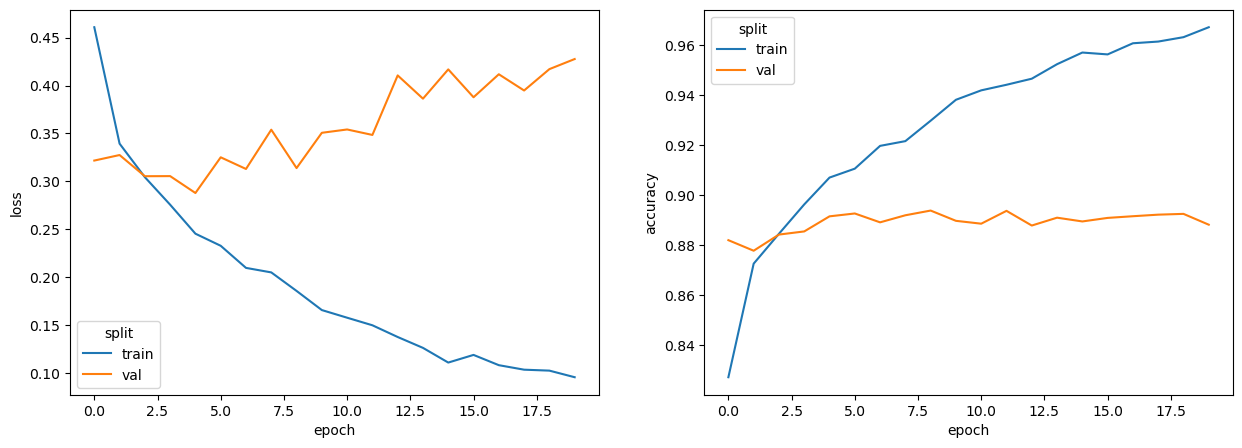

In [38]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[0])

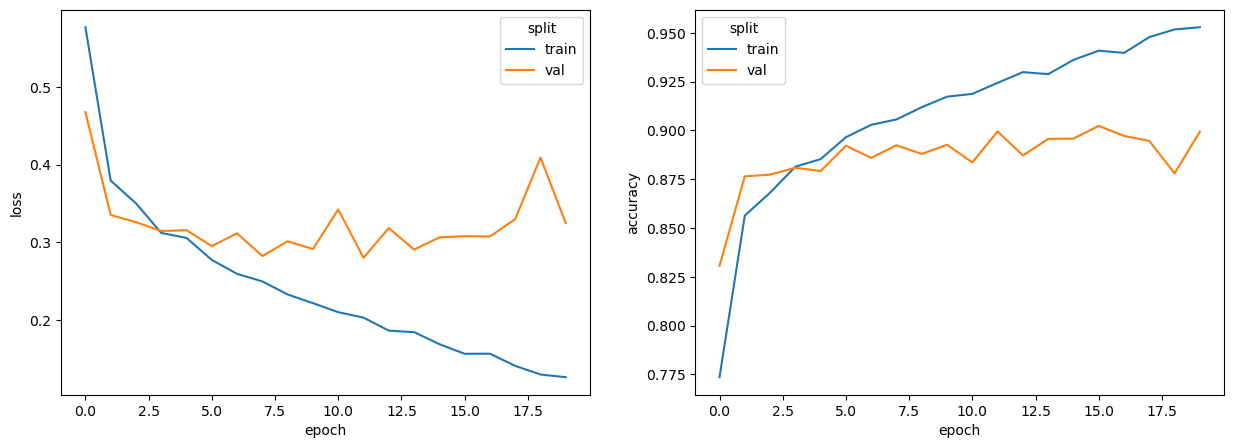

In [39]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[1])

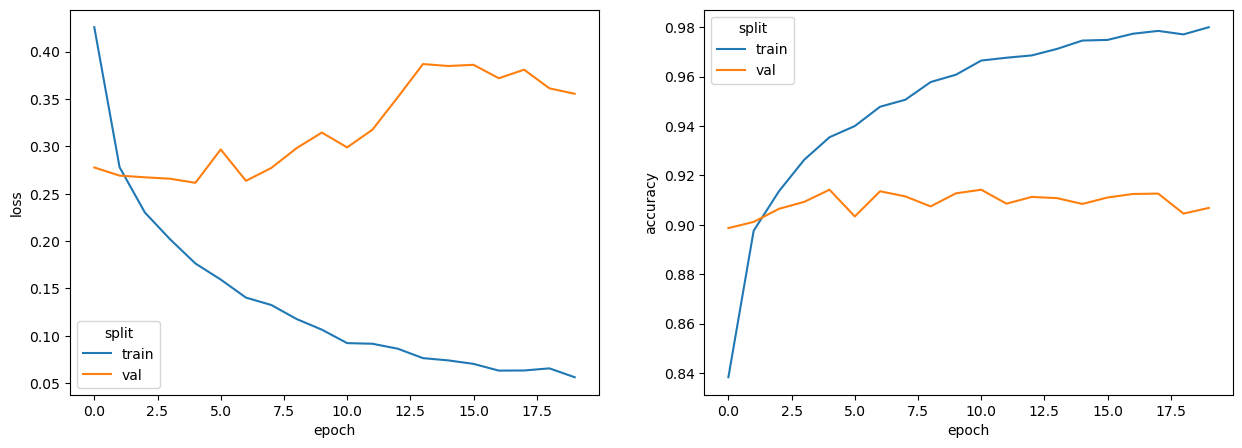

In [40]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[2])

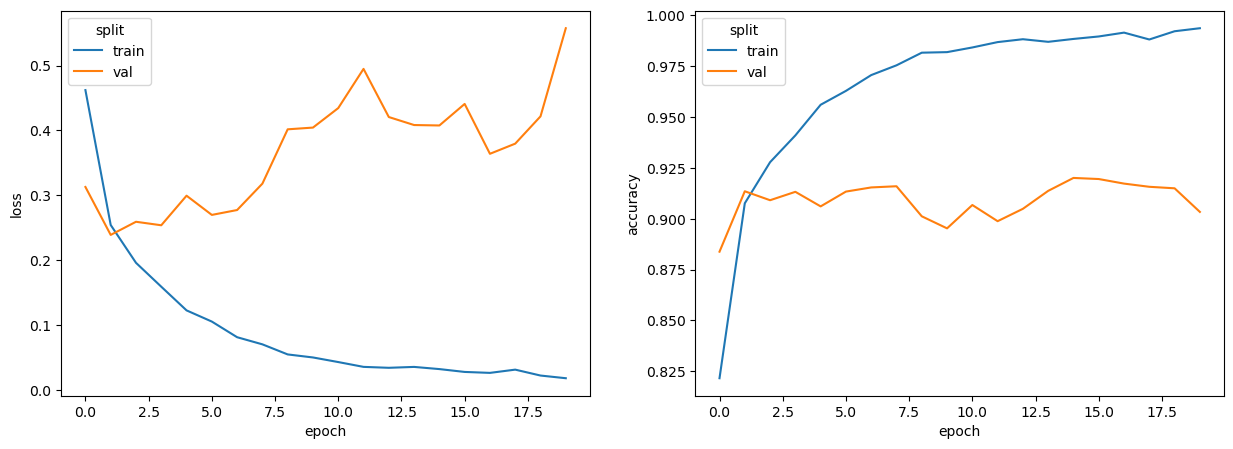

In [41]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[3])

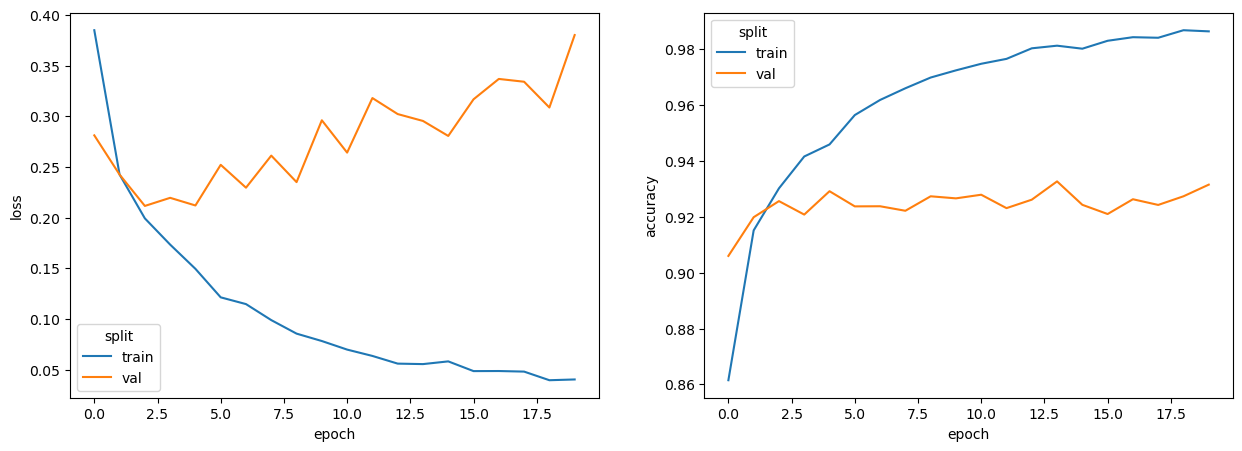

In [42]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[4])

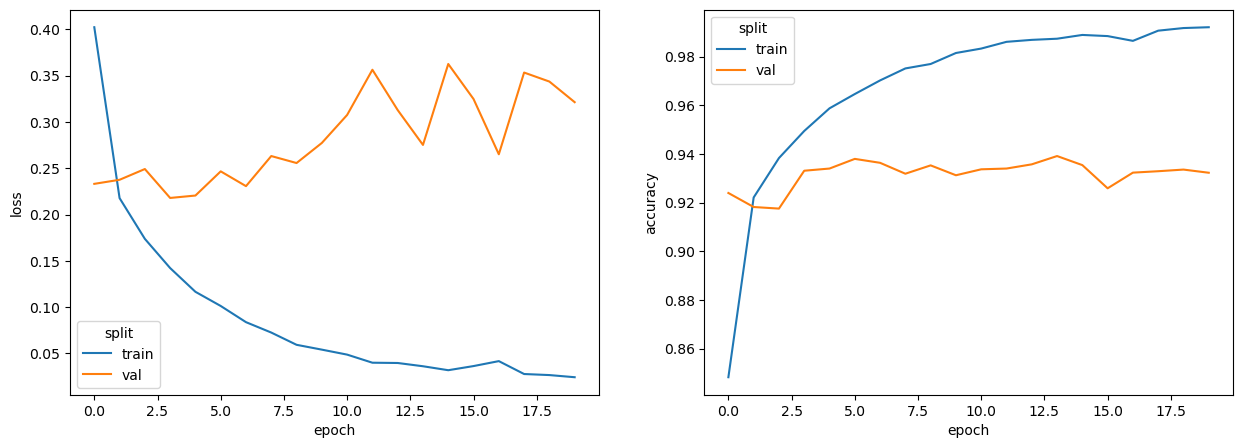

In [43]:
plot_loss_accuracy(HISTORY_FOLDER,FIGURES_FOLDER,model_names[5])

### Evaluation

In [44]:
metrics = {
    "accuracy" : Accuracy(task="multiclass",num_classes=num_classes).to(DEVICE),
    "f1_score" : F1Score(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
    "precision" : Precision(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
    "recall" : Recall(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
    "auc" : AUROC(task="multiclass",num_classes=num_classes,average="macro").to(DEVICE),
}

In [45]:
def compute(models, model_name : str, metrics : dict[str,Metric]):

    Y_hat = []
    Y = []

    test_loader = models[model_name]["test_loader"]
    model = models[model_name]["model"].eval()

    with torch.inference_mode():
        
        for x,y in tqdm(test_loader):

            x, y = x.to(DEVICE), y.to(DEVICE)

            y_hat = model(x)

            Y_hat.append(y_hat)
            Y.append(y)

    Y_hat = torch.cat(Y_hat)
    Y = torch.cat(Y)

    results = {}

    for name,metric in metrics.items():
        results[name] = metric(Y_hat,Y).cpu().numpy()

    return pd.Series(data=results,name=model_name)

In [46]:
def evaluate(models : dict, metrics : dict[str,Metric]) -> pd.DataFrame:

    df = pd.DataFrame()

    for name in models.keys():

        print(f"Evaluating : {name}")

        df[name] = compute(models, name, metrics)

    return df

In [47]:
evaluate(models, metrics)

Evaluating : net=EfficientNet&depth=0


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=ShuffleNet&depth=0


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=EfficientNet&depth=1


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=ShuffleNet&depth=1


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=EfficientNet&depth=2


  0%|          | 0/199 [00:00<?, ?it/s]

Evaluating : net=ShuffleNet&depth=2


  0%|          | 0/199 [00:00<?, ?it/s]

,net=EfficientNet&depth=0,net=ShuffleNet&depth=0,net=EfficientNet&depth=1,net=ShuffleNet&depth=1,net=EfficientNet&depth=2,net=ShuffleNet&depth=2
accuracy,0.8885039,0.89952755,0.90677166,0.90362203,0.9313386,0.93228346
f1_score,0.8994417,0.9062955,0.91589737,0.91042316,0.93756837,0.93900007
precision,0.9073316,0.9142523,0.9095464,0.91335845,0.9458666,0.93352
recall,0.8920276,0.8988395,0.9230544,0.91312873,0.93039423,0.9448135
auc,0.97688496,0.9810165,0.984826,0.9828558,0.98784405,0.98994887
